In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

### Índice y consideración sobre el precio

Para nuestro análisis disponemos del campo 'Adj. Close', que se trata del precio de cierre descontando los efectos de acciones corporativas como pago de dividendos, splits, etc., ideal para un análisis a largo plazo como el nuestro.
Para el etiquetado de nuestros registros, deberemos obtener un índice del sector bancario del tipo 'Total return', calculado también de forma que se excluyen los efectos de los pagos de dvidendos u otras acciones.
Probamos con el Dow Jones U.S. Financials Index, obteniendo información histórica desde 2008 en Yahoo Finance https://finance.yahoo.com/quote/%5EDJUSFN/

In [2]:
# Volcamos en un dataframe los datos obtenidos del índide
bank_index = pd.read_csv('../datos/banks_index.csv')
bank_index['Date']=pd.to_datetime(bank_index['Date'], format="%Y-%m-%d")

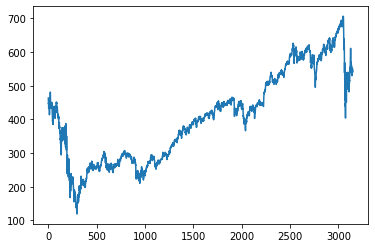

In [3]:
bank_index['DJUSF'].plot();

## Etiquetado

En este momento disponemos de tres tablas diferentes:

- mergedbalres
- banks_cotiz
- bank_index

Para poder asignar a cada trimestre analizado la etiqueta adecuada debemos seguir los siguientes pasos:

    1) Volcar el precio desde banks_cotiz en la fecha de publicación de resultados en cada registro de mergedbalres.
    2) Volcar el precio desde banks_cotiz en la fecha de publicación de resultados + 90 días en cada registro de mergedbalres.
    3) Volcar el precio desde Bank_index para el Ticker correspondiente en la fecha de publicación de resultados en cada registro de mergedbalres.
    4) Volcar el precio desde Bank_index para el Ticker correspondiente en la fecha de publicación de resultados + 90 días en cada registro de mergedbalres.
    5) Calcular en mergedbalres, para cada registro, la variación porcentual tanto del índice como del Ticker.
    6) Comparar ambas variaciones y asignar la etiqueta correspondiente: entre +1% y -1% 'neutro'; más de 1% a favor de Ticker 'mejor'; menos de -1% con respecto índice 'peor'.

### 1) Precio de Bank_cotiz a mergedbalres en d (fecha de publicación)

In [4]:
mergedbalres = pd.read_csv('../tablas/mergedbalres.csv', index_col='Ref')
banks_cotiz = pd.read_csv('../datos/banks_cotiz.csv', sep=',', date_parser='Dates', usecols=('Ticker', 'Date', 'Adj. Close'))

In [5]:
banks_cotiz.head(2)

,Ticker,Date,Adj. Close
0,WFC,2007-01-03,24.12
1,WFC,2007-01-04,24.16


In [6]:
# Incorporamos el campo 'Adj. Close' a la tabla mergedbalres con la función merged
mergedbalres_with_prices = mergedbalres.merge(banks_cotiz, 
                                              left_on=('Ticker','Publish Date'),
                                              right_on=('Ticker','Date'), 
                                              how='left')
mergedbalres_with_prices.drop('Date', axis=1, inplace=True)

In [7]:
# Cambiamos el nombre del campo 'Adj. Close' para referirnos claramente al precio en el día inicial del periodo
mergedbalres_with_prices.rename(columns={'Adj. Close':'Price_d'}, inplace=True)
mergedbalres_with_prices.head(5)

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),...,Total Non-Interest Expense,Operating Income (Loss),Non-Operating Income (Loss),Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Extraordinary Gains (Losses),Net Income,Net Income (Common),Price_d
0,BAC,71941,USD,2011,Q3,2011-09-30,2011-11-03,2011-11-03,1.011628e+10,1.046440e+10,...,-17437000000,7609000000,NaN,7433000000,-1.201000e+09,6232000000,NaN,6232000000,5889000000,6.17
1,BAC,71941,USD,2011,Q4,2011-12-31,2012-02-23,2013-02-28,1.028341e+10,1.027862e+10,...,-18840000000,3114000000,NaN,2432000000,-4.410000e+08,1991000000,NaN,1991000000,1584000000,7.17
2,BAC,71941,USD,2012,Q1,2012-03-31,2012-05-03,2012-05-03,1.065137e+10,1.076192e+10,...,-19141000000,719000000,NaN,719000000,-6.600000e+07,653000000,NaN,653000000,328000000,7.16
3,BAC,71941,USD,2012,Q2,2012-06-30,2012-08-02,2012-08-02,1.077570e+10,1.155601e+10,...,-17048000000,3147000000,NaN,3147000000,-6.840000e+08,2463000000,NaN,2463000000,2098000000,6.44
4,BAC,71941,USD,2012,Q3,2012-09-30,2012-11-02,2012-11-02,1.077617e+10,1.077617e+10,...,-17544000000,1110000000,NaN,1110000000,-7.700000e+08,340000000,NaN,340000000,-33000000,8.84


### 2) Precio de Bank_cotiz a mergedbalres en d+90

In [8]:
from datetime import timedelta

In [9]:
#Transformamos los campos de fechas a Timestamp, para poder añadirle los 90 días del periodo

mergedbalres_with_prices['Publish Date']=pd.to_datetime(mergedbalres_with_prices['Publish Date'],
                                                        format="%Y-%m-%d")

banks_cotiz['Date']=pd.to_datetime(banks_cotiz['Date'], format="%Y-%m-%d")

mergedbalres_with_prices['Publish_Date+90']=mergedbalres_with_prices['Publish Date'] + timedelta(days=90)

In [10]:
#Cruzamos ambas tablas

mergedbalres_with_prices = mergedbalres_with_prices.merge(banks_cotiz, 
                                                          left_on=('Ticker','Publish_Date+90'),
                                                          right_on=('Ticker','Date'), 
                                                          how='left')

mergedbalres_with_prices.drop('Date', axis=1, inplace=True)

# Cambiamos el nombre del campo 'Adj. Close' para referirnos al precio en el día final del periodo

mergedbalres_with_prices.rename(columns={'Adj. Close':'Price_d+90'}, inplace=True)

### 3) Precio de Bank_index a mergedbalres en d (fecha de publicación)

In [11]:
# Incorporamos el campo 'DJUSF a la tabla mergedbalres_with_prices con la función merged
mergedbalres_with_prices = mergedbalres_with_prices.merge(bank_index, 
                                              left_on=('Publish Date'),
                                              right_on=('Date'), 
                                              how='left')
mergedbalres_with_prices.drop('Date', axis=1, inplace=True)
mergedbalres_with_prices.rename(columns={'DJUSF':'DJUSF_d'}, inplace=True)

### 4) Precio de Bank_index a mergedbalres en d+90 (fecha de publicación)

In [12]:
#Cruzamos los precios de Bank Index con la fecha d+90

mergedbalres_with_prices = mergedbalres_with_prices.merge(bank_index, 
                                                          left_on=('Publish_Date+90'),
                                                          right_on=('Date'), 
                                                          how='left')

mergedbalres_with_prices.drop('Date', axis=1, inplace=True)

# Cambiamos el nombre del campo DJUSF para referirnos al valor del índice en el día final del periodo

mergedbalres_with_prices.rename(columns={'DJUSF':'DJUSF_d+90'}, inplace=True)

### 5) Calcular en mergedbalres, para cada registro, la variación porcentual tanto del índice como del Ticker.

In [13]:
mergedbalres_with_prices['Var_cotiz']=(mergedbalres_with_prices['Price_d+90']-mergedbalres_with_prices['Price_d'])/mergedbalres_with_prices['Price_d']
mergedbalres_with_prices['Var_index']=(mergedbalres_with_prices['DJUSF_d+90']-mergedbalres_with_prices['DJUSF_d'])/mergedbalres_with_prices['DJUSF_d']

### 6) Comparar ambas variaciones y asignar la etiqueta correspondiente: entre +1% y -1% 'neutro'; más de 1% a favor de Ticker 'mejor'; menos de -1% con respecto índice 'peor'.

In [14]:
def etiquetado(row):
    limite = 0.02
    dif = row['Var_cotiz'] - row['Var_index']
    if dif > limite:
        return 'Mejor'
    elif dif < -limite:
        return 'Peor'
    else:
        return 'Neutral'

In [15]:
mergedbalres_with_prices['Etiqueta']=mergedbalres_with_prices.apply(etiquetado,axis=1)

In [16]:
mergedbalres_with_prices.head(5)

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),...,Net Income,Net Income (Common),Price_d,Publish_Date+90,Price_d+90,DJUSF_d,DJUSF_d+90,Var_cotiz,Var_index,Etiqueta
0,BAC,71941,USD,2011,Q3,2011-09-30,2011-11-03,2011-11-03,1.011628e+10,1.046440e+10,...,6232000000,5889000000,6.17,2012-02-01,6.58,250.201996,266.403015,0.066451,0.064752,Neutral
1,BAC,71941,USD,2011,Q4,2011-12-31,2012-02-23,2013-02-28,1.028341e+10,1.027862e+10,...,1991000000,1584000000,7.17,2012-05-23,6.42,274.470001,264.872986,-0.104603,-0.034966,Peor
2,BAC,71941,USD,2012,Q1,2012-03-31,2012-05-03,2012-05-03,1.065137e+10,1.076192e+10,...,653000000,328000000,7.16,2012-08-01,6.47,285.774994,274.437012,-0.096369,-0.039675,Peor
3,BAC,71941,USD,2012,Q2,2012-06-30,2012-08-02,2012-08-02,1.077570e+10,1.155601e+10,...,2463000000,2098000000,6.44,2012-10-31,8.36,272.450012,294.502014,0.298137,0.080940,Mejor
4,BAC,71941,USD,2012,Q3,2012-09-30,2012-11-02,2012-11-02,1.077617e+10,1.077617e+10,...,340000000,-33000000,8.84,2013-01-31,10.17,296.191986,321.622986,0.150452,0.085860,Mejor


Por último, guardamos la tabla obtenida

In [18]:
mergedbalres_with_prices.to_csv('../tablas/registros_etiq.csv', index=False)